In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense, dot, concatenate
from keras.layers import Activation, BatchNormalization
from keras.layers import TimeDistributed, Flatten
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf,keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from collections import Counter
from keras.models import load_model, save_model

%matplotlib notebook

In [70]:
data = pd.read_csv('train.csv')
# Remove rows with NaN in the first row
data = data.dropna(subset=[data.columns[0]])

# Reset the index after dropping the row
data = data.reset_index(drop=True)

data['label'] = data['label']
# Your signal values and corresponding labels
signal_values = data['SOP']  # Replace with your actual data
labels = data['label']


In [71]:
data['SOP'].max()

0.018983666

In [4]:
data_test = pd.read_csv('test.csv')
# Remove rows with NaN in the first row
data_test = data_test.dropna(subset=[data_test.columns[0]])

# Reset the index after dropping the row
data_test = data_test.reset_index(drop=True)

data_test['label'] =data_test['label']
# Your signal values and corresponding labels
signal_values_test = data_test['SOP']  # Replace with your actual data
labels_test = data_test['label']


In [5]:
signal_values= np.array(signal_values)
signal_values_test= np.array(signal_values_test)

In [6]:
len(labels)

41354

In [7]:
len(signal_values)

41354

<IPython.core.display.Javascript object>


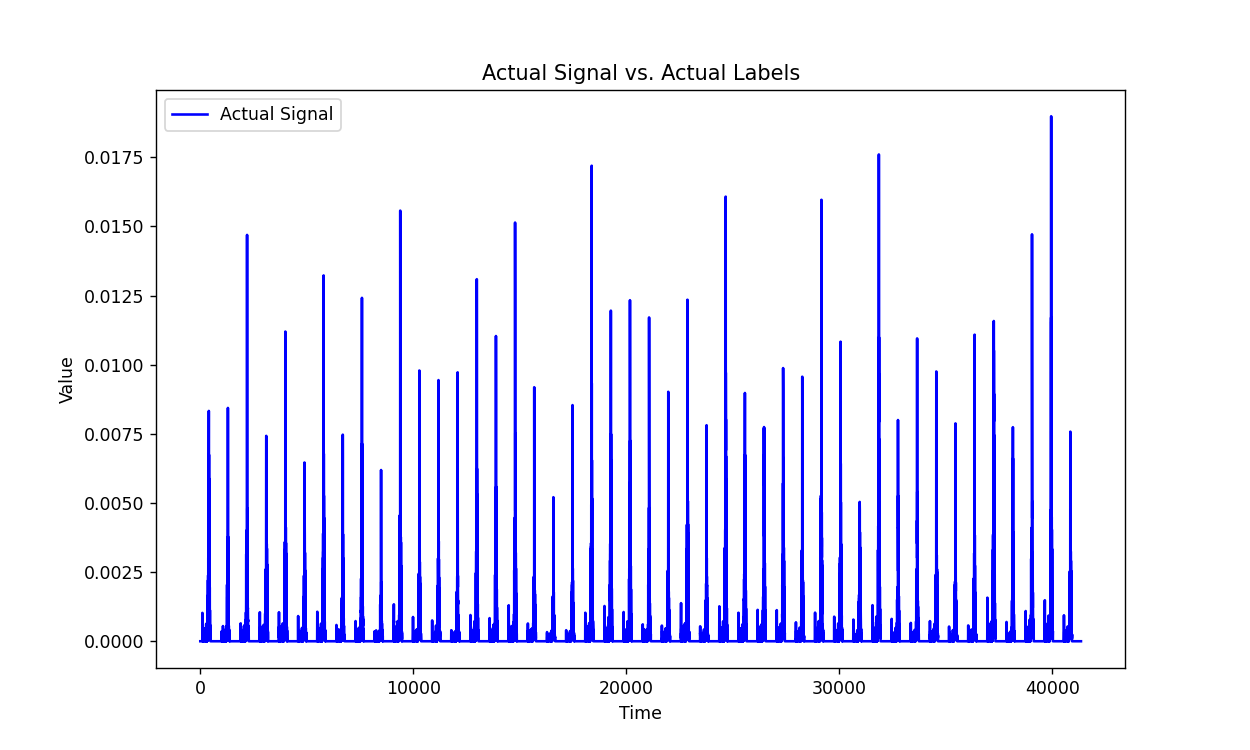

In [8]:
# Visualize predicted labels and actual signal
plt.figure(figsize=(10, 6))
plt.plot(signal_values, label='Actual Signal', color='blue')
#plt.plot(labels, label='Actual Labels', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual Signal vs. Actual Labels')
plt.legend()
plt.show()

In [9]:

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

signal_values = signal_values.reshape(-1, 1)
signal_values_test = signal_values_test.reshape(-1, 1)
# Step 3: Prepare data for LSTM
def prepare_data_for_lstm(X, y, time_steps):
    X_lstm, y_lstm = [], []
    for i in range(len(X)-time_steps):
        X_lstm.append(X[i:i+time_steps])
        y_lstm.append(y[i+time_steps])
    return np.array(X_lstm), np.array(y_lstm)

time_steps = 20 # Adjust this based on your specific use case

X_lstm, y_lstm = prepare_data_for_lstm(signal_values, labels, time_steps)
X_lstm_test, y_lstm_test = prepare_data_for_lstm(signal_values_test, labels_test, time_steps)
# Step 4: Split data into training and testing sets
# Train test splitt
X_train,X_test,y_train,y_test=train_test_split(X_lstm,y_lstm,test_size=0.2,random_state=42, stratify=y_lstm)


# Define input layer
inputs = Input(shape=(time_steps, signal_values.shape[1]))

# First LSTM layer
lstm_out1 = LSTM(64, return_sequences=True)(inputs)

# Second LSTM layer
lstm_out2 = LSTM(128, return_sequences=True)(lstm_out1)  # Add another LSTM layer here
lstm_out3 = LSTM(64, return_sequences=True)(lstm_out2)
lstm_out4 = LSTM(64, return_sequences=True)(lstm_out3)
# Attention mechanism
attention_probs = TimeDistributed(Dense(1, activation='relu'))(lstm_out4)
attention_probs = Activation('softmax', name='attention_probs')(attention_probs)
attention_mul = dot([attention_probs, lstm_out4], axes=1)
attention_mul = Flatten()(attention_mul)

# Fully connected layer
output = Dense(4, activation='softmax')(attention_mul)


# Build the model
model = Model(inputs=[inputs], outputs=output)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape input data to match LSTM input shape (samples, time steps, features)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)




In [ ]:
# Train the model with early stopping
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])



# Make predictions
predictions = model.predict(X_test)

# Convert predictions to binary labels
binary_predictions = np.round(predictions)

print("Predictions:\n", binary_predictions)

In [10]:
model.load_weights('final_model.h5')

In [11]:
from sklearn.metrics import classification_report

# Make predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(y_test, predicted_labels)
print(report)


259/259 [==============================] - 5s 14ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5507
           1       0.99      0.98      0.98       681
           2       0.98      0.98      0.98      1343
           3       1.00      0.99      0.99       736

    accuracy                           0.99      8267
   macro avg       0.99      0.99      0.99      8267
weighted avg       0.99      0.99      0.99      8267



In [12]:
# Make predictions
predictions_test = model.predict(X_lstm_test)
predicted_labels = np.argmax(predictions_test, axis=1)

# Generate classification report
report = classification_report(y_lstm_test, predicted_labels)
print(report)

927/927 [==============================] - 12s 13ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19747
           1       0.96      0.95      0.95      2442
           2       0.96      0.96      0.96      4818
           3       0.97      0.97      0.97      2640

    accuracy                           0.98     29647
   macro avg       0.97      0.97      0.97     29647
weighted avg       0.98      0.98      0.98     29647



<IPython.core.display.Javascript object>


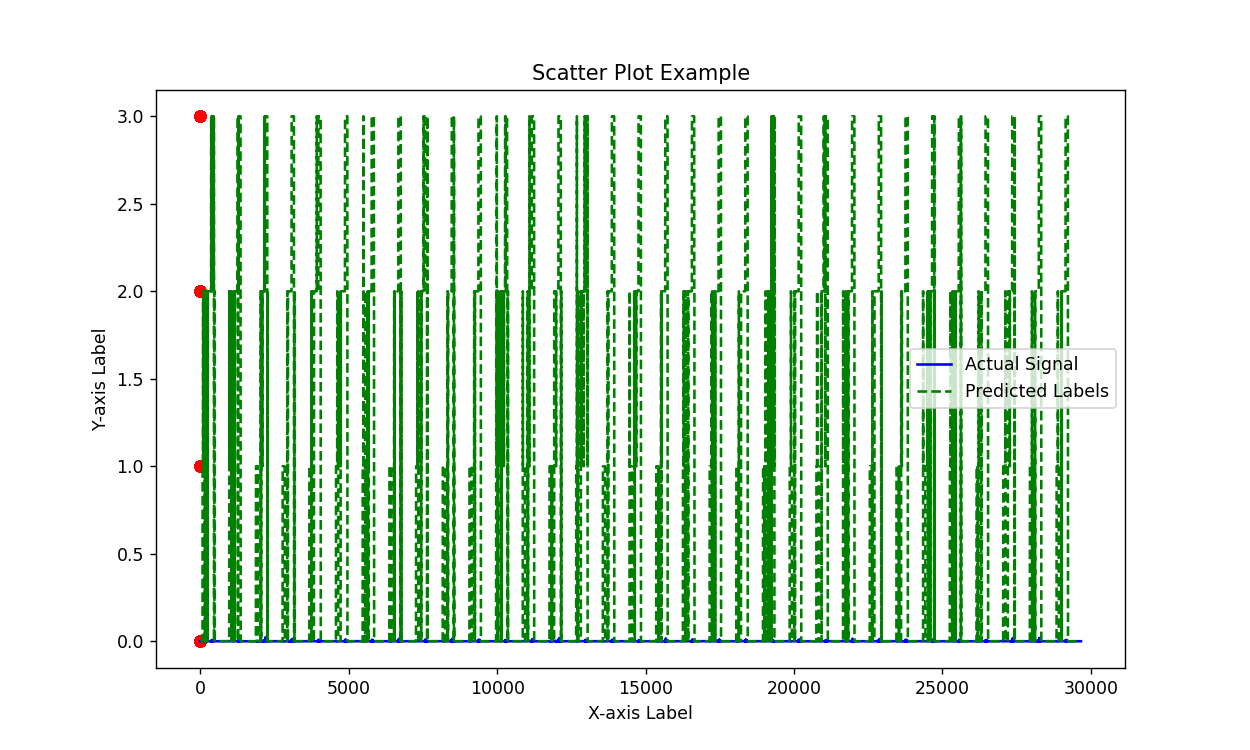

In [13]:
# Visualize predicted labels and actual signal
plt.figure(figsize=(10, 6))

# Assuming `predicted_labels` is your predicted labels array
#predicted_labels = np.random.randint(0, 4, len(signal_values_test))  # Generate random predicted labels for demonstration

plt.plot(signal_values_test, label='Actual Signal', color='blue')
plt.plot(predicted_labels, label='Predicted Labels', color='green', linestyle='dashed')  # Change color to green
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual Signal vs. Predicted Labels')  # Update title
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


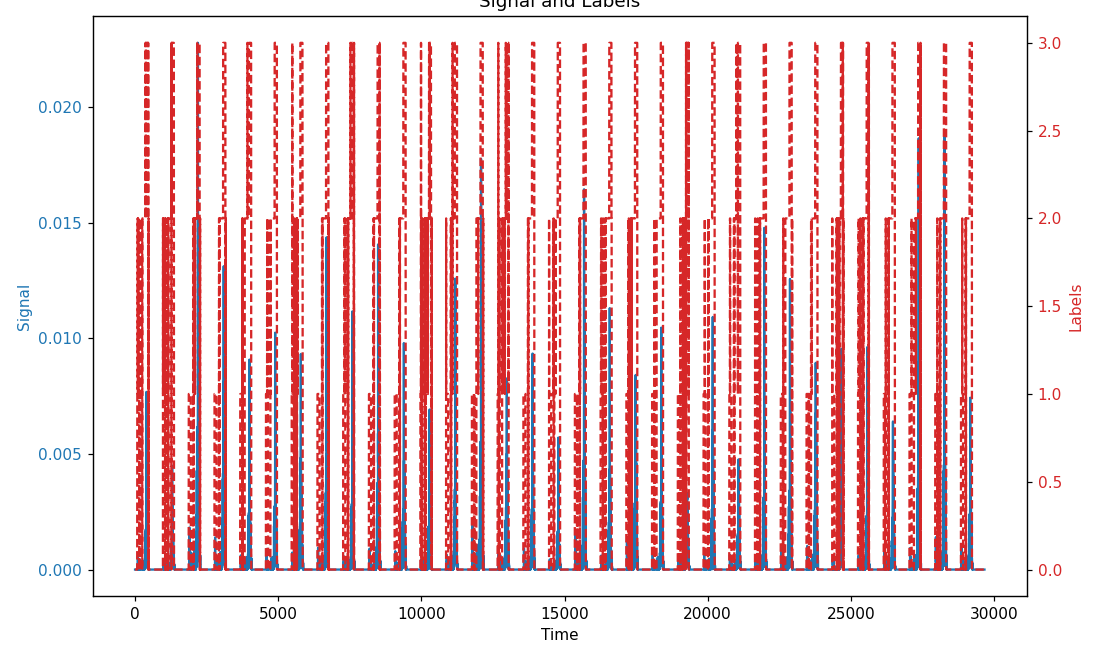

In [33]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot signal values
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Signal', color=color)
ax1.plot(signal_values_test, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for labels
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Labels', color=color)
ax2.plot(predicted_labels, color=color, linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Signal and Labels')
plt.show()


In [34]:
 len(predicted_labels)

29647

In [35]:
len(labels_test)

29667

In [36]:
predicted_labels=predicted_labels.reshape(-1,1)

In [37]:
predicted_labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [38]:
labels_test

0        0
1        0
2        0
3        0
4        0
        ..
29662    0
29663    0
29664    0
29665    0
29666    0
Name: label, Length: 29667, dtype: int64

In [39]:
import csv

    # Replace with your actual actual labels

# Create a list of tuples where each tuple contains the corresponding predicted and actual label
data = list(zip(predicted_labels, labels_test))

# Define the CSV file path
csv_file_path = 'predicted_data.csv'

# Write data to the CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Predicted Label', 'Actual Label'])  # Write header row
    writer.writerows(data)  # Write the data

print(f'Data written to {csv_file_path}')


Data written to predicted_data.csv


**Testing On Real World Data:**

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [149]:
real_data=pd.read_csv('SOP_1.csv')
real_data.head(5)

,time,SOP,label
0,0.005,0.000033,0
1,0.010,0.000000,0
2,0.015,0.000004,0
3,0.020,0.000000,0
4,0.025,0.000000,0


In [150]:
# Remove rows with NaN in the first row
real_data = real_data.dropna(subset=[real_data.columns[0]])

# Reset the index after dropping the row
real_data = real_data.reset_index(drop=True)

In [151]:
real_data['label'][99]

1

In [152]:
real_data.isna().sum()

time     0
SOP      0
label    0
dtype: int64

In [153]:
train_class1=[]
for index,value in data['label'].items():
    if value==2:
        train_class1.append(data['SOP'][index])

In [157]:
print(min(train_class1))

0.0


In [155]:
real_class1=[]
for index,value in real_data['label'].items():
    if value==2:
        real_class1.append(real_data['SOP'][index])

In [156]:
print(max(real_class1))

0.000362977


In [158]:
target_class=2
class_rows = real_data[real_data['label'] == target_class]
sop_values = class_rows['SOP'].values.reshape(-1, 1)
original_indices = class_rows.index
scaler = MinMaxScaler(feature_range=(0.0,0.015148556 ))
scaled_sop_values = scaler.fit_transform(sop_values)
scaled_sop_values = scaler.fit_transform(sop_values).flatten()

In [159]:
max(scaled_sop_values)

0.015148556

In [160]:
for index,value in enumerate(scaled_sop_values):
    real_data['SOP'][original_indices[index]]=value
    

C:\Users\Dell pc\AppData\Local\Temp\ipykernel_13372\4236696346.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data['SOP'][original_indices[index]]=value


<IPython.core.display.Javascript object>


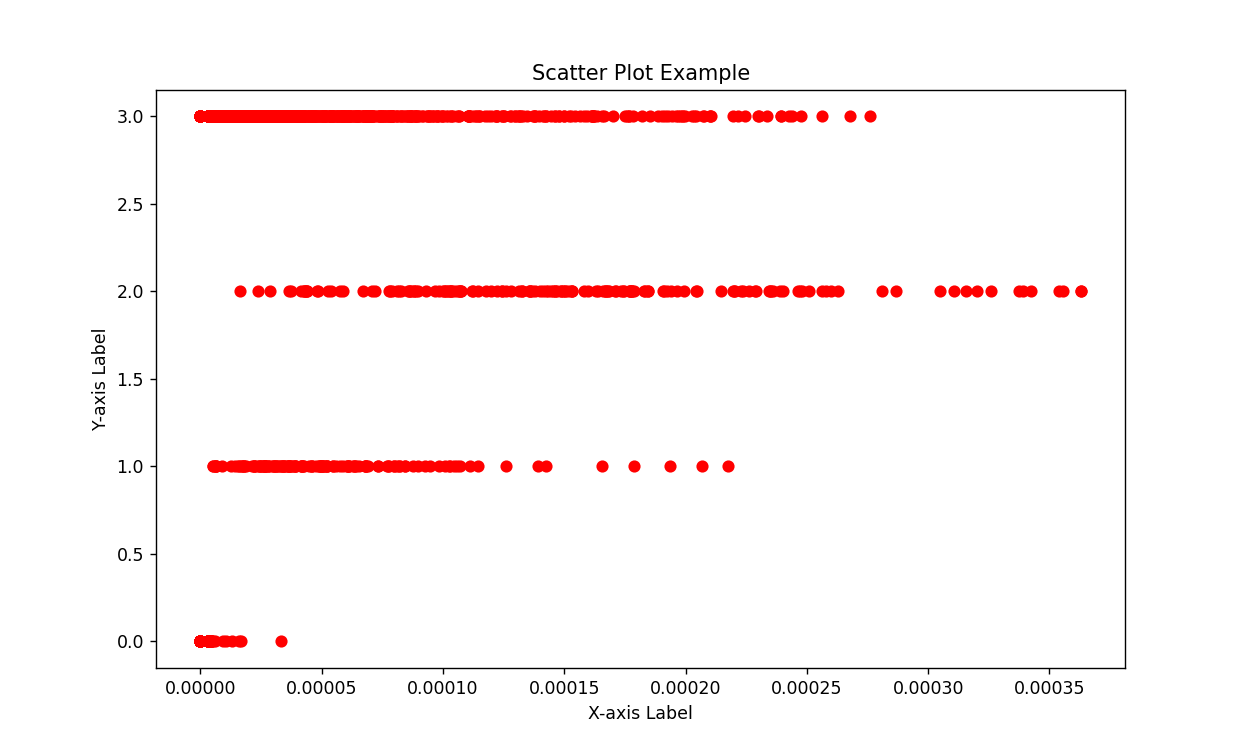

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(real_data['SOP'],real_data['label'], color='red')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot Example')
plt.show()

In [25]:
# #0.018983666
# scaler = MinMaxScaler(feature_range=(0.0,0.018983666 ))
# real_data['SOP']=scaler.fit_transform(real_data[['SOP']])

In [161]:
series=real_data['SOP']
labels=real_data['label']

In [162]:
def prepare_data_for_lstm(X, y, time_steps):
    X_lstm, y_lstm = [], []
    for i in range(len(X)-time_steps):
        X_lstm.append(X[i:i+time_steps])
        y_lstm.append(y[i+time_steps])
    return np.array(X_lstm), np.array(y_lstm)

In [163]:
series= np.array(series)
series=series.reshape(-1,1)

In [164]:
features, y_true = prepare_data_for_lstm(series, labels, time_steps=20)

In [165]:
predictions_real_data=model.predict(features)
predictions_real_data = np.argmax(predictions_real_data, axis=1)


# Generate classification report
report = classification_report(y_true, predictions_real_data)
print(report)

44/44 [==============================] - 1s 31ms/step
              precision    recall  f1-score   support

           0       0.11      1.00      0.19        79
           1       0.23      0.44      0.30       141
           2       0.15      0.17      0.16       160
           3       0.24      0.04      0.07      1001

    accuracy                           0.15      1381
   macro avg       0.18      0.41      0.18      1381
weighted avg       0.22      0.15      0.11      1381

